## Solución Practica

#### Objetivo: Predecir el precio del airbnb a partir del dataset proporcionado.

In [1]:
import sys  
sys.path.insert(1, "C:/Users/ASUS/Documents/GitHub/Machine-Learning-101")

In [2]:
from utils import plot_decision_boundary, poly_linear_regression, CM_BRIGHT

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

## 1. Carga de datos y división train/test

In [5]:
from sklearn.model_selection import train_test_split

airbnb_data = pd.read_csv("./airbnb-listings-extract.csv", delimiter=";")
train, test = train_test_split(airbnb_data, test_size=0.3, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardar datos por separado
train.to_csv('./airbnb-listings_train.csv', sep=';', decimal='.', index=False)
test.to_csv('./airbnb-listings_test.csv', sep=';', decimal='.', index=False)

# Cargar el dataset de train
airbnb_train_data = pd.read_csv('./airbnb-listings_train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (10346, 89)
Dimensiones del dataset de test: (4434, 89)


In [470]:
# Cargar el dataset de train
airbnb_train_data = pd.read_csv('./airbnb-listings_train.csv', sep=';', decimal='.')

## 2. Análisis exploratorio

### 2.1 Revisar la estructura de los datos:

In [384]:
# Revisar las primeras filas y su contenido
train_head = airbnb_train_data.head()
train_info = airbnb_train_data.info()
train_describe = airbnb_train_data.describe(include='all')

train_head
# , train_info, train_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10346 non-null  int64  
 1   Listing Url                     10346 non-null  object 
 2   Scrape ID                       10346 non-null  int64  
 3   Last Scraped                    10346 non-null  object 
 4   Name                            10345 non-null  object 
 5   Summary                         9922 non-null   object 
 6   Space                           7619 non-null   object 
 7   Description                     10340 non-null  object 
 8   Experiences Offered             10346 non-null  object 
 9   Neighborhood Overview           6397 non-null   object 
 10  Notes                           3960 non-null   object 
 11  Transit                         6327 non-null   object 
 12  Access                          

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,2156319,https://www.airbnb.com/rooms/2156319,20170407214119,2017-04-08,GRANT VII Plaza Mayor,NaN,Beautiful and charming apartment recently deco...,Beautiful and charming apartment recently deco...,none,NaN,...,9.0,10.0,9.0,NaN,NaN,strict,40.0,0.24,"40.4154180336,-3.70712273935","Host Has Profile Pic,Host Identity Verified,Is..."
1,3377153,https://www.airbnb.com/rooms/3377153,20170407214119,2017-04-08,Nice flat in Plaza Mayor (lift),"Flat is in the centre town, really close to Pl...",You cannot find a better location to stay in M...,"Flat is in the centre town, really close to Pl...",none,"It´s really cool, with a lot of new business (...",...,10.0,10.0,9.0,NaN,NaN,flexible,1.0,5.61,"40.411131472,-3.7072583983","Host Has Profile Pic,Host Identity Verified,Is..."
2,14800635,https://www.airbnb.com/rooms/14800635,20170407214119,2017-04-08,* ROOM double Barrio Salamanca *,"Private room for two persons has a double bed,...",It is a penthouse located in the salamanca dis...,"Private room for two persons has a double bed,...",none,The District of Salamanca is one of the 21 dis...,...,10.0,10.0,10.0,NaN,NaN,flexible,3.0,5.45,"40.4280496724,-3.6760419089","Host Has Profile Pic,Host Identity Verified,Re..."
3,11185674,https://www.airbnb.com/rooms/11185674,20170407214119,2017-04-08,cheap apartment in Madrid city cent,"Cheap apartment, next to Madrid rio, just four...",NaN,"Cheap apartment, next to Madrid rio, just four...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,0.16,"40.3964492726,-3.71409988867","Host Has Profile Pic,Is Location Exact,Require..."
4,18092171,https://www.airbnb.com/rooms/18092171,20170407214119,2017-04-08,"ACOGEDOR APARTAMENTO EN MADRID, CALLE MANZANARES","Acogedor apartamento, para parejas y/o familia.",NaN,"Acogedor apartamento, para parejas y/o familia.",none,NaN,...,NaN,NaN,NaN,NaN,NaN,strict,3.0,NaN,"40.4134467958,-3.71843838152","Host Has Profile Pic,Is Location Exact,Require..."


### [RUN] Eliminar columnas que considero que no aportan información relevante para predecir el precio.

In [472]:
def eliminar_columnas (dataset): 
    return dataset.drop(['Access','Calendar last Scraped','Calendar Updated','Cancellation Policy','Description','Experiences Offered','Features', 'Host Since',
                         'First Review','Latitude','Longitude','Has Availability','Host About','Host ID','Host Location','Host Name','Host Neighbourhood','Host Picture Url','Host Response Rate',
                         'Host Response Time','Host Thumbnail Url','Host URL','Host Verifications','House Rules','ID','Interaction','Jurisdiction Names','Last Review',
                         'Last Scraped','License','Listing Url','Medium Url','Name','Neighborhood Overview','Neighbourhood Group Cleansed','Neighbourhood',
                         'Notes','Picture Url', 'Scrape ID','Space','Summary','Thumbnail Url','Transit','XL Picture Url'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}') 
airbnb_train_data = eliminar_columnas(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

Cantidad de columnas antes de borrar: 89
Cantidad de columnas después de borrar: 45


In [49]:
# Revisar las primeras filas y su contenido
train_head = airbnb_train_data.head()
train_info = airbnb_train_data.info()
train_describe = airbnb_train_data.describe(include='all')

train_head
# , train_info, train_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      10344 non-null  object 
 1   Host Acceptance Rate            25 non-null     object 
 2   Host Listings Count             10344 non-null  float64
 3   Host Total Listings Count       10344 non-null  float64
 4   Street                          10346 non-null  object 
 5   Neighbourhood Cleansed          10346 non-null  object 
 6   City                            10342 non-null  object 
 7   State                           10240 non-null  object 
 8   Zipcode                         9999 non-null   object 
 9   Market                          10307 non-null  object 
 10  Smart Location                  10346 non-null  object 
 11  Country Code                    10346 non-null  object 
 12  Country                         

,Host Since,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Street,Neighbourhood Cleansed,City,State,Zipcode,Market,...,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month,Geolocation
0,2012-01-25,NaN,40.0,40.0,"Sol, Madrid, Community of Madrid 28013, Spain",Sol,Madrid,Community of Madrid,28013,Madrid,...,9,93.0,10.0,9.0,9.0,10.0,9.0,40.0,0.24,"40.4154180336,-3.70712273935"
1,2014-06-20,NaN,1.0,1.0,"La Latina, Madrid, Comunidad de Madrid 28005, ...",Embajadores,Madrid,Comunidad de Madrid,28005,Madrid,...,182,92.0,9.0,9.0,10.0,10.0,9.0,1.0,5.61,"40.411131472,-3.7072583983"
2,2016-08-05,NaN,3.0,3.0,"Madrid, Comunidad de Madrid 28006, Spain",Goya,Madrid,Comunidad de Madrid,28006,Madrid,...,38,97.0,10.0,9.0,10.0,10.0,10.0,3.0,5.45,"40.4280496724,-3.6760419089"
3,2015-05-06,NaN,1.0,1.0,"Carabanchel, Madrid, Comunidad de Madrid 28019...",Comillas,Madrid,Comunidad de Madrid,28019,Madrid,...,2,80.0,NaN,NaN,NaN,NaN,NaN,1.0,0.16,"40.3964492726,-3.71409988867"
4,2017-03-29,NaN,4.0,4.0,"Imperial, Madrid, Comunidad de Madrid 28005, S...",Imperial,Madrid,Comunidad de Madrid,28005,Madrid,...,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,"40.4134467958,-3.71843838152"


In [51]:
airbnb_train_data[['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']]

,Host Listings Count,Host Total Listings Count,Calculated host listings count
0,40.0,40.0,40.0
1,1.0,1.0,1.0
2,3.0,3.0,3.0
3,1.0,1.0,1.0
4,4.0,4.0,3.0
...,...,...,...
10341,1.0,1.0,1.0
10342,2.0,2.0,1.0
10343,1.0,1.0,1.0
10344,1.0,1.0,1.0


Valores faltantes por columna: 
 Host Listings Count               2
Host Total Listings Count         2
Calculated host listings count    4
dtype: int64


Correlaciones con el precio:
Host Listings Count               0.230518
Host Total Listings Count         0.230518
Calculated host listings count    0.224751
Price                             1.000000
Name: Price, dtype: float64


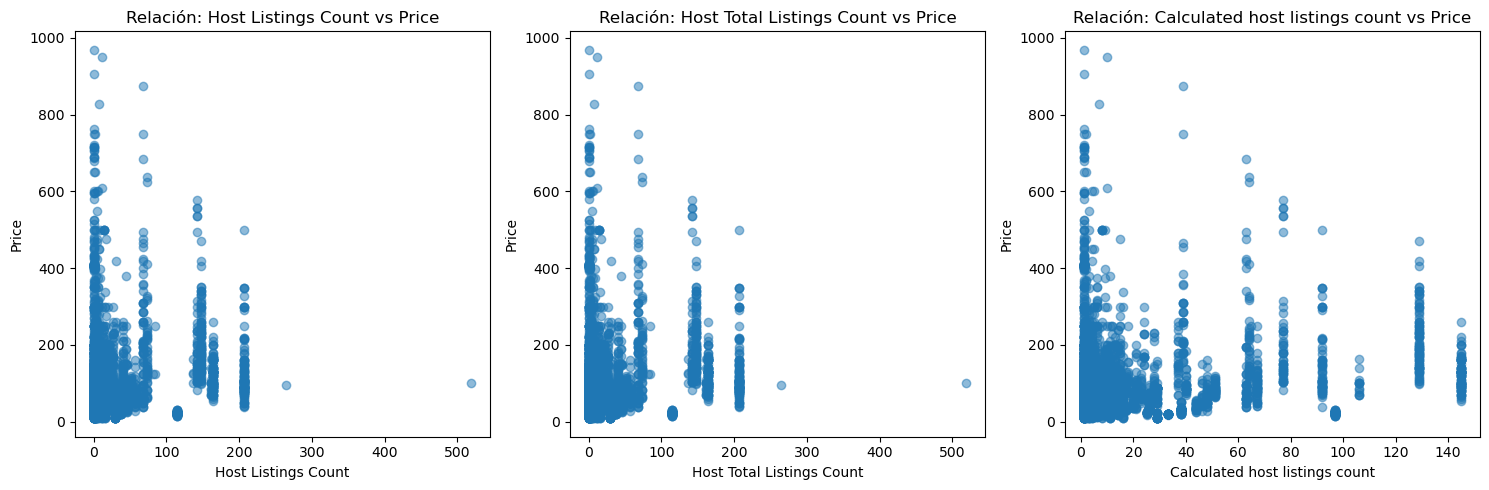

In [230]:
print(f"Valores faltantes por columna: \n {airbnb_train_data[['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']].isnull().sum()}")

print("\n")

correlations = airbnb_train_data[['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count', 'Price']].corr()
print("Correlaciones con el precio:")
print(correlations['Price'])

# Visualizar relación con el precio
plt.figure(figsize=(15, 5))
for i, columna in enumerate(['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count'], 1):
    plt.subplot(1, 3, i)
    plt.scatter(airbnb_train_data[columna], airbnb_train_data['Price'], alpha=0.5)
    plt.title(f'Relación: {columna} vs Price')
    plt.xlabel(columna)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

### [RUN] Eliminar columnas ronda 2

In [474]:
def eliminar_columnas_ronda_dos (dataset): 
    return dataset.drop(['Host Total Listings Count', 'Host Listings Count'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}') 
airbnb_train_data = eliminar_columnas_ronda_dos(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

Cantidad de columnas antes de borrar: 45
Cantidad de columnas después de borrar: 43


### Conclusiones

* **ID, Listing Url, Scrape ID, Host ID, Host URL, Picture Url, Thumbnail Url, etc.**, son identificadores únicos o enlaces que no aportan información valiosa.
* **Last Scraped, Name, Summary, Description, Experiences Offered, Neighborhood Overview, Notes, Street, etc.**, contienen texto descriptivo que probablemente no tenga un impacto significativo en este caso.
* **First Review y Last Review**: contiene fechas de la primera y última reseña que no aportan valor significativo.
* **Calendar Updated y Calendar last Scraped**: proveen información de cuándo se actualizó o descargó el calendario de disponibilidad y esto no es relevante para el calculo del precio.
* **Latitud y Longitud:** Es redudante porque ya tenemos Geolocation.
* **Availability 30, Availability 60, Availability 90, Availability 365**: considero que no son relevantes para calcular el precio. Estan mas enfocadas a proveer informacion sobre disponibilidad en diferentes intervalos de tiempo.
* **Host Total Listings Count y Listings Count**: Tienen correlaciones similares con el precio y probablemente son redundantes comparada con Calculated Host Listings Count, pero está podria representar una versión derivada más precisa.

### 2.2 Detectar valores faltantes y outliers

### Valores faltantes

In [124]:
airbnb_train_data.isnull().sum()

Host Since                            2
Host Acceptance Rate              10321
Street                                0
Neighbourhood Cleansed                0
City                                  4
State                               106
Zipcode                             347
Market                               39
Smart Location                        0
Country Code                          0
Country                               1
Property Type                         0
Room Type                             0
Accommodates                          0
Bathrooms                            38
Bedrooms                             20
Beds                                 34
Bed Type                              0
Amenities                           131
Square Feet                        9936
Price                                14
Weekly Price                       7833
Monthly Price                      7844
Security Deposit                   5899
Cleaning Fee                       4222


In [476]:
def mostrar_porcentaje_valores_faltantes(dataset):
    porcentaje_valores_faltantes = dataset.isnull().mean() * 100
    print("Porcentaje de valores faltantes por columna:")
    print(porcentaje_valores_faltantes[porcentaje_valores_faltantes > 0].sort_values(ascending=False))

mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Porcentaje de valores faltantes por columna:
Host Acceptance Rate              99.758361
Square Feet                       96.037116
Monthly Price                     75.816741
Weekly Price                      75.710419
Security Deposit                  57.017205
Cleaning Fee                      40.808042
Review Scores Value               22.994394
Review Scores Location            22.975063
Review Scores Checkin             22.955732
Review Scores Accuracy            22.907404
Review Scores Communication       22.868742
Review Scores Cleanliness         22.868742
Review Scores Rating              22.723758
Reviews per Month                 21.708873
Zipcode                            3.353953
Amenities                          1.266190
State                              1.024551
Market                             0.376957
Bathrooms                          0.367292
Beds                               0.328629
Bedrooms                           0.193311
Price                          

### [RUN] Se descartaran las columnas que tienen mas del 70% de valores faltantes:
- Host Acceptance Rate (99.76%)
- Square Feet (96.04%)
- Monthly Price (75.82%)
- Weekly Price (75.71%)

In [478]:
def eliminar_columnas_na (dataset): 
    return dataset.drop(['Host Acceptance Rate', 'Square Feet', 'Monthly Price', 'Weekly Price'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}')
airbnb_train_data = eliminar_columnas_na(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Cantidad de columnas antes de borrar: 43
Cantidad de columnas después de borrar: 39
Porcentaje de valores faltantes por columna:
Security Deposit                  57.017205
Cleaning Fee                      40.808042
Review Scores Value               22.994394
Review Scores Location            22.975063
Review Scores Checkin             22.955732
Review Scores Accuracy            22.907404
Review Scores Communication       22.868742
Review Scores Cleanliness         22.868742
Review Scores Rating              22.723758
Reviews per Month                 21.708873
Zipcode                            3.353953
Amenities                          1.266190
State                              1.024551
Market                             0.376957
Bathrooms                          0.367292
Beds                               0.328629
Bedrooms                           0.193311
Price                              0.135318
Calculated host listings count     0.038662
City                               

### Imputación de valores

In [393]:
print(airbnb_train_data[['Bathrooms']].value_counts().sort_index())
print(airbnb_train_data[['Beds']].value_counts().sort_index())
print(airbnb_train_data[['Bedrooms']].value_counts().sort_index())

Bathrooms
0.0            44
0.5            49
1.0          7716
1.5           384
2.0          1624
2.5            90
3.0           226
3.5            20
4.0            54
4.5            16
5.0            50
5.5             4
6.0            23
6.5             1
7.0             3
7.5             1
8.0             3
Name: count, dtype: int64
Beds
1.0     5123
2.0     2697
3.0     1151
4.0      650
5.0      269
6.0      170
7.0       77
8.0       73
9.0       29
10.0      39
11.0       4
12.0       7
13.0       5
14.0       5
15.0       3
16.0      10
Name: count, dtype: int64
Bedrooms
0.0          707
1.0         6812
2.0         1833
3.0          651
4.0          213
5.0           68
6.0           24
7.0            8
8.0            5
10.0           5
Name: count, dtype: int64


In [395]:
airbnb_train_data[['Bathrooms', 'Beds', 'Bedrooms']].describe()

,Bathrooms,Beds,Bedrooms
count,10308.000000,10312.000000,10326.000000
mean,1.289726,2.053627,1.347376
std,0.668635,1.626308,0.904172
min,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,2.000000,1.000000
75%,1.000000,2.000000,2.000000
max,8.000000,16.000000,10.000000


### [RUN] Imputare los valores nulos de tipo numerico con la mediana ya que no quiero que se vean afectado por los outliers.

In [480]:
columnas_numericas = ['Bathrooms', 'Beds', 'Bedrooms', 'Price', 'Cleaning Fee', 'Review Scores Rating', 'Review Scores Accuracy', 
                     'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 
                     'Review Scores Value', 'Reviews per Month', 'Calculated host listings count']

for columna in columnas_numericas:
    airbnb_train_data[columna] = airbnb_train_data[columna].fillna(airbnb_train_data[columna].median())

mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Porcentaje de valores faltantes por columna:
Security Deposit    57.017205
Zipcode              3.353953
Amenities            1.266190
State                1.024551
Market               0.376957
City                 0.038662
Country              0.009666
dtype: float64


In [399]:
airbnb_train_data[['Security Deposit']].describe()

,Security Deposit
count,4447.000000
mean,188.551158
std,115.648243
min,0.000000
25%,100.000000
50%,150.000000
75%,200.000000
max,990.000000


### [RUN] Imputare los valores nulos de Security Deposit con 0

In [482]:
airbnb_train_data['Security Deposit'] = airbnb_train_data['Security Deposit'].fillna(0)
mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Porcentaje de valores faltantes por columna:
Zipcode      3.353953
Amenities    1.266190
State        1.024551
Market       0.376957
City         0.038662
Country      0.009666
dtype: float64


#### Validar porcentaje de filas restantes con valores nulos

In [484]:
columnas_con_valores_nulos = [
    'State', 'Zipcode', 'Market', 
    'City', 'Amenities', 'Country'
]
datase_filas_eliminadas = airbnb_train_data.dropna(subset=columnas_con_valores_nulos)
total_filas_antes = airbnb_train_data.shape[0]
total_filas_despues = datase_filas_eliminadas.shape[0]

print(
    f'Original: {total_filas_antes} // '
    f'Modificado: {total_filas_despues}\nDiferencia: {total_filas_antes - total_filas_despues}'
)
print(f'Variación: {((total_filas_antes - total_filas_despues)/total_filas_antes)*100:2f}%')

Original: 10346 // Modificado: 9734
Diferencia: 612
Variación: 5.915330%


### [RUN] Imputare los valores nulos de las filas restantes con la moda para no perder el 5% de la información.

In [488]:
airbnb_train_data[columnas_con_valores_nulos].mode()

,State,Zipcode,Market,City,Amenities,Country
0,Comunidad de Madrid,28012,Madrid,Madrid,"TV,Internet,Wireless Internet,Air conditioning...",Spain


In [486]:
# Rellenar valores nulos con la moda
for columna in columnas_con_valores_nulos:
    moda = airbnb_train_data[columna].mode()[0]
    airbnb_train_data[columna] = airbnb_train_data[columna].fillna(moda)

# Verificar si quedan valores nulos
print("Valores nulos después de la imputación:")
print(airbnb_train_data[columnas_con_valores_nulos].isnull().sum())

Valores nulos después de la imputación:
State        0
Zipcode      0
Market       0
City         0
Amenities    0
Country      0
dtype: int64


In [412]:
airbnb_train_data.describe()

airbnb_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Street                          10346 non-null  object 
 1   Neighbourhood Cleansed          10346 non-null  object 
 2   City                            10346 non-null  object 
 3   State                           10346 non-null  object 
 4   Zipcode                         10346 non-null  object 
 5   Market                          10346 non-null  object 
 6   Smart Location                  10346 non-null  object 
 7   Country Code                    10346 non-null  object 
 8   Country                         10346 non-null  object 
 9   Property Type                   10346 non-null  object 
 10  Room Type                       10346 non-null  object 
 11  Accommodates                    10346 non-null  int64  
 12  Bathrooms                       

In [490]:
airbnb_train_data.isnull().sum()

Street                            0
Neighbourhood Cleansed            0
City                              0
State                             0
Zipcode                           0
Market                            0
Smart Location                    0
Country Code                      0
Country                           0
Property Type                     0
Room Type                         0
Accommodates                      0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Bed Type                          0
Amenities                         0
Price                             0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Availability 30                   0
Availability 60                   0
Availability 90                   0
Availability 365            

In [284]:
airbnb_train_data.isnull().sum()

Street                            0
Neighbourhood Cleansed            0
City                              0
State                             0
Zipcode                           0
Market                            0
Smart Location                    0
Country Code                      0
Country                           0
Property Type                     0
Room Type                         0
Accommodates                      0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Bed Type                          0
Amenities                         0
Price                             0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Availability 30                   0
Availability 60                   0
Availability 90                   0
Availability 365            

### Identificar outliers en columnas numéricas

In [494]:
def obtener_columnas_numericas():
    return airbnb_train_data.select_dtypes(include=['float64', 'int64']).columns
    
columnas_numericas_outliers = obtener_columnas_numericas()
columnas_numericas_outliers

Index(['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Calculated host listings count',
       'Reviews per Month'],
      dtype='object')

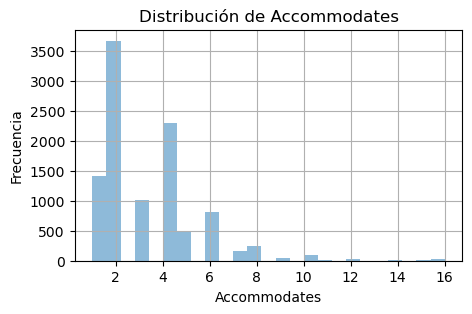

In [506]:
def grafica_frecuencia_por_columnas(activarBreak = True):
    for columna in obtener_columnas_numericas():
        plt.figure(figsize=(5, 3))  # Ajusta el tamaño de cada figura individual
        airbnb_train_data[columna].plot.hist(alpha=0.5, bins=25, grid=True)
        plt.xlabel(columna)
        plt.ylabel("Frecuencia")
        plt.title(f"Distribución de {columna}")
        plt.show()
        
        if activarBreak: 
            break

grafica_frecuencia_por_columnas(activarBreak = True)

#### Relación entre `Price` y las columnas numéricas

<Figure size 1500x500 with 0 Axes>

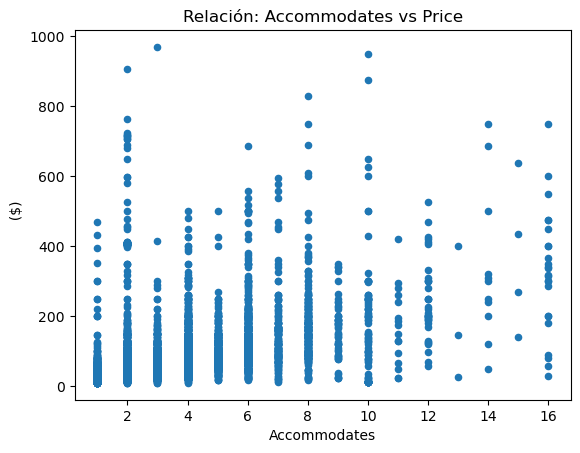

In [511]:
plt.figure(figsize=(15, 5))
for i, columna in enumerate(obtener_columnas_numericas(), 1):
    if columna != 'Price':
        airbnb_train_data.plot(kind = 'scatter',x=columna,y = 'Price')
        plt.title(f"Relación: {columna} vs Price")
        plt.xlabel(columna)
        plt.ylabel('  ($)')
        break
plt.show()

### Conclusiones
* Existe una relación positiva entre Accommodates y Price, alojamientos con mayor capacidad tienden a ser más caros.
    * En alojamientos con mayor capacidad (más de 8 personas) el precio tiende a ser consistentemente más alto.
* Tambien hay una relación positiva entre Bathrooms y Price, más baños generalmente estan asociados con alojamientos más caros.
    * El precio generalmente aumenta con el número de baños pero hay menos alojamientos con más de 3 baños.
    * Algunos alojamientos con 2-3 baños tienen precios muy altos, lo mas probablemente es que sea debido a factores externos.
* Los precios más altos están asociados con alojamientos que tienen puntuaciones de limpieza de 9 o 10.
* No veo relación fuerte de los campos Review Scores Communication y Review Scores Checkin con el precio.

### [RUN] Eliminar columnas redudantes ronda 3

In [502]:
def eliminar_columnas_ronda_tres (dataset): 
    return dataset.drop(['Review Scores Communication', 'Review Scores Checkin', 'Availability 30', 'Availability 60', 'Availability 90'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}') 
airbnb_train_data = eliminar_columnas_ronda_tres(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

Cantidad de columnas antes de borrar: 39
Cantidad de columnas después de borrar: 34


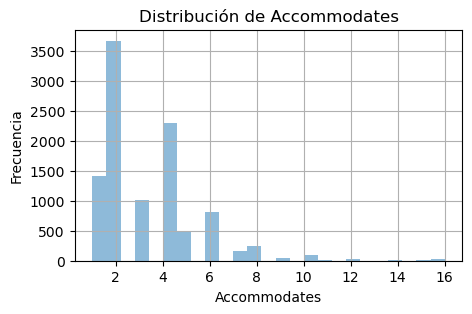

In [513]:
grafica_frecuencia_por_columnas(activarBreak = True)